# Choose Cluster

In [1]:
cluster_input = 18
cluster = str(cluster_input)
clust_to_celltype = {1: 'excitatory_neurons', 2: 'inhibitory_neurons', 3: 'excitatory_neurons',
                     4: 'excitatory_neurons', 5: 'nigral_neurons', 6: 'nigral_neurons', 7: 'unknown_neurons',
                     8: 'opcs', 9: 'opcs', 10: 'opcs', 11: 'inhibitory_neurons',12: 'inhibitory_neurons',
                     13: 'astrocytes', 14: 'astrocytes', 15: 'astrocytes', 16: 'astrocytes', 17: 'astrocytes',
                     18: 'doublets', 19: 'oligodendrocytes', 20: 'oligodendrocytes', 21: 'oligodendrocytes',
                     22: 'oligodendrocytes', 23: 'oligodendrocytes', 24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

# Quick Links

<ol>
    <li><a href=#prep_sig_scores>Prepare Significance Scores</a></li>
    <li><a href=#prep_conf_scores>Prepare Confidence Scores</a></li>
    <li><a href=#prep_score_df>Prepare Score DataFrames</a></li>
    <li><a href=#plot_score_distrib>Plot Score Distributions</a></li>
    <li><a href=#calculate_pvals>Calculate P-Values</a></li>
    <li><a href=#visualize_high_conf>Visualize High Confidence SNPs</a></li>
    <li><a href=#prep_final_table>Prepare Final SNPs Table</a></li>
</ol>

## Imports

In [2]:
# Basic

import sys
import math
import random
import statistics
from decimal import Decimal

# Data / ML / Stats Libraries

import numpy as np
import pandas as pd
import scipy
from scipy.stats import *
pd.set_option('display.max_columns', None)

# Visualization

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from plotnine import *
sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *
plt.style.use('default')

## Addresses

In [3]:
real_base = '/mnt/lab_data3/soumyak/adpd/'
real_effect_fasta = real_base + 'fasta_inputs/Cluster' + cluster + '.effect.fasta'
real_noneffect_fasta = real_base + 'fasta_inputs/Cluster' + cluster + '.noneffect.fasta'
null_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'

## Get Input Sequences

In [4]:
real_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(real_effect_fasta)) if i%2==1]
real_effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in real_effect_seqs]

print('Num Real effect sequences:', '\t', '\t', len(real_effect_onehot))

real_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(real_noneffect_fasta)) if i%2==1]
real_noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in real_noneffect_seqs]

print('Num Real noneffect sequences:', '\t', '\t', len(real_noneffect_onehot))

Num Real effect sequences: 	 	 237
Num Real noneffect sequences: 	 	 237


# Prepare Real Scores <a name='prep_sig_scores' />

In [5]:
merged_real_effect_scores = np.zeros(shape=(len(real_effect_seqs), 1000, 4))
merged_real_noneffect_scores = np.zeros(shape=(len(real_noneffect_seqs), 1000, 4))
merged_real_explain_scores = np.zeros(shape=(len(real_effect_seqs),))

for fold in range(10):
    real_effect_file = real_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores.txt'
    real_effect_scores = get_hyp_scores(real_effect_file, real_effect_seqs)
    real_effect_scores = np.array(real_effect_scores)
    merged_real_effect_scores = merged_real_effect_scores + real_effect_scores
    
    real_noneffect_file = real_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores.txt'
    real_noneffect_scores = get_hyp_scores(real_noneffect_file, real_noneffect_seqs)
    real_noneffect_scores = np.array(real_noneffect_scores)
    merged_real_noneffect_scores = merged_real_noneffect_scores + real_noneffect_scores
       
    real_explain_scores = []
    
    for i,j in enumerate(real_effect_scores): # iterate over sequences
        real_50bp_imp_effect = np.sum(np.array([np.sum(j) \
                                for j in \
                                real_effect_scores[i][475:525]]))
        real_50bp_imp_noneffect = np.sum(np.array([np.sum(j) \
                                    for j in \
                                    real_noneffect_scores[i][475:525]]))
        real_explain_score_seq = real_50bp_imp_effect - real_50bp_imp_noneffect
        real_explain_scores.append(real_explain_score_seq)
    
    merged_real_explain_scores = merged_real_explain_scores + np.array(real_explain_scores)
    
merged_real_effect_scores = merged_real_effect_scores / (fold + 1)
merged_real_noneffect_scores = merged_real_noneffect_scores / (fold + 1)
merged_real_explain_scores = merged_real_explain_scores / (fold + 1)

print('Num Real GkmExplain scores:', '\t', '\t', len(merged_real_explain_scores))
print('Num Real Effect scores:', '\t', '\t', len(merged_real_effect_scores))
print('Num Real Non-Effect scores:', '\t', '\t', len(merged_real_noneffect_scores))

#--------------------------------------------------------#

merged_real_ism_scores = np.zeros(shape=(len(real_effect_seqs),))
merged_real_delta_scores = np.zeros(shape=(len(real_effect_seqs),))

for fold in range(10):
    real_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(real_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    real_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(real_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    merged_real_ism_scores = merged_real_ism_scores + real_ism_scores
    merged_real_delta_scores = merged_real_delta_scores + real_delta_scores
        
merged_real_ism_scores = merged_real_ism_scores / (fold + 1)
merged_real_delta_scores = merged_real_delta_scores / (fold + 1)

print('Num Real ISM scores:', '\t', '\t', '\t', len(merged_real_ism_scores))
print('Num Real deltaSVM scores:', '\t', '\t', len(merged_real_delta_scores))

Num Real GkmExplain scores: 	 	 237
Num Real Effect scores: 	 	 237
Num Real Non-Effect scores: 	 	 237
Num Real ISM scores: 	 	 	 237
Num Real deltaSVM scores: 	 	 237


# Prepare Null Scores

In [6]:
null_importance_scores = []
merged_null_effect_scores = []
merged_null_noneffect_scores = []
merged_null_explain_scores = []

for fold in range(10):
    for shuf in range(10):
        null_effect_file = null_base + 'shuffled_explain_scores/Cluster' \
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.effect.scores'
        null_effect_scores = get_scores(null_effect_file)
                
        null_noneffect_file = null_base + 'shuffled_explain_scores/Cluster' \
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.noneffect.scores'
        null_noneffect_scores = get_scores(null_noneffect_file)
        
        for i,j in enumerate(null_effect_scores):
            merged_null_effect_scores.append([sum(k) for k in null_effect_scores[i]])
            merged_null_noneffect_scores.append([sum(k) for k in null_noneffect_scores[i]])
            
for i,j in enumerate(merged_null_effect_scores):
    null_effect_50bp = sum(merged_null_effect_scores[i][75:125])
    null_noneffect_50bp = sum(merged_null_noneffect_scores[i][75:125])
    null_explain_score = null_effect_50bp - null_noneffect_50bp
    merged_null_explain_scores.append(null_explain_score)
    
    for k,l in enumerate(merged_null_effect_scores[i]):
        null_importance_scores.append(l)
        assert l == merged_null_effect_scores[i][k]                
            
print('Num Null importance scores:', '\t', len(null_importance_scores))
print('Num Null GkmExplain scores:', '\t', len(merged_null_explain_scores))
    
#--------------------------------------------------------#

merged_null_ism_scores = []
merged_null_delta_scores = []

for fold in range(10):
    for shuf in range(10):
        null_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                            for i in open(null_base + 'shuffled_ism_scores/Cluster'
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.ism.scores').readlines()])
        null_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                for i in open(null_base + 'shuffled_delta_scores/Cluster'
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.delta.scores').readlines()])
        for null_i_score in null_ism_scores:
            merged_null_ism_scores.append(null_i_score)
        for null_d_score in null_delta_scores:
            merged_null_delta_scores.append(null_d_score)

print('Num Null ISM scores:', '\t', '\t', len(merged_null_ism_scores))
print('Num Null deltaSVM scores:', '\t', len(merged_null_delta_scores))

Num Null importance scores: 	 4500000
Num Null GkmExplain scores: 	 22500
Num Null ISM scores: 	 	 22500
Num Null deltaSVM scores: 	 22500


# Get Real Confidence Scores <a name='prep_conf_scores' />

In [7]:
real_confidence_dict = {'real_center_start': [], 'real_center_end': [],
                        'real_center_effect': [], 'real_center_noneffect': [],
                        'real_bg_effect': [], 'real_bg_noneffect': [],
                        'real_magnitude_score': [], 'real_prominence_score': [],
                        'real_active_allele': [], 'real_inactive_allele': [],
                        'real_center_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.95)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(real_effect_seqs)):
    real_per_seq_dict = {'real_scores_active': [], 'real_scores_inactive': [],
                         'real_scores_effect': [], 'real_scores_noneffect': [],
                         'real_active_allele': ''}
    real_center_start = 0
    real_center_end = 0
    real_center_effect = 0
    real_center_noneffect = 0
    real_bg_effect = 0
    real_bg_noneffect = 0
    
    real_effect_total = np.sum(np.array([np.sum(i) for i in merged_real_effect_scores[seq][475:525]]))
    real_noneffect_total = np.sum(np.array([np.sum(i) for i in merged_real_noneffect_scores[seq][475:525]]))
    real_per_seq_dict['real_scores_effect'] = [np.sum(j) for j in merged_real_effect_scores[seq]]
    real_per_seq_dict['real_scores_noneffect'] = [np.sum(j) for j in merged_real_noneffect_scores[seq]]
    if real_effect_total >= real_noneffect_total:
        real_per_seq_dict['real_active_allele'] = 'effect'
        real_per_seq_dict['real_inactive_allele'] = 'noneffect'
        real_confidence_dict['real_active_allele'].append('effect')
        real_confidence_dict['real_inactive_allele'].append('noneffect')
    else:
        real_per_seq_dict['real_active_allele'] = 'noneffect'
        real_per_seq_dict['real_inactive_allele'] = 'effect'
        real_confidence_dict['real_active_allele'].append('noneffect')
        real_confidence_dict['real_inactive_allele'].append('effect')
    real_per_seq_dict['real_scores_active'] = real_per_seq_dict['real_scores_'+real_per_seq_dict['real_active_allele']]
    real_per_seq_dict['real_scores_inactive'] = real_per_seq_dict['real_scores_'+real_per_seq_dict['real_inactive_allele']]
    
    start = 499
    end = 499
    while True:
        if real_per_seq_dict['real_scores_active'][start - 1] <= null_upper_thresh:
            if real_per_seq_dict['real_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if real_per_seq_dict['real_scores_active'][end] <= null_upper_thresh:
            if real_per_seq_dict['real_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != end:
        real_motif_len = end - start
        if (real_motif_len) < 7:
            real_center_start = start - math.floor((10 - real_motif_len) / 2)
            real_center_end = end + math.ceil((10 - real_motif_len) / 2)
        else:
            real_center_start = start
            real_center_end = end
    else:
        real_center_start = start - 4
        real_center_end = end + 6
    
    real_confidence_dict['real_center_start'].append(real_center_start)
    real_confidence_dict['real_center_end'].append(real_center_end)
    real_confidence_dict['real_center_len'].append(real_center_end - real_center_start)
    
    for i,j in enumerate(real_per_seq_dict['real_scores_active'][real_center_start:real_center_end]):
        if real_per_seq_dict['real_scores_effect'][i+real_center_start] >= 0:
            real_center_effect += real_per_seq_dict['real_scores_effect'][i+real_center_start]
        if real_per_seq_dict['real_scores_noneffect'][i+real_center_start] >= 0:
            real_center_noneffect += real_per_seq_dict['real_scores_noneffect'][i+real_center_start]
        assert j == real_per_seq_dict['real_scores_active'][i+real_center_start]
    for i,j in enumerate(real_per_seq_dict['real_scores_active']):
        if real_per_seq_dict['real_scores_effect'][i] >= 0:
            real_bg_effect += real_per_seq_dict['real_scores_effect'][i]
        if real_per_seq_dict['real_scores_noneffect'][i] >= 0:
            real_bg_noneffect += real_per_seq_dict['real_scores_noneffect'][i]
        assert j == real_per_seq_dict['real_scores_active'][i]
    
    real_magnitude_score = real_center_effect - real_center_noneffect
    real_prominence_score = (real_center_effect / real_bg_effect) - (real_center_noneffect / real_bg_noneffect)
    
    real_confidence_dict['real_center_effect'].append(real_center_effect)
    real_confidence_dict['real_center_noneffect'].append(real_center_noneffect)
    real_confidence_dict['real_bg_effect'].append(real_bg_effect)
    real_confidence_dict['real_bg_noneffect'].append(real_bg_noneffect)
    real_confidence_dict['real_magnitude_score'].append(real_magnitude_score)
    real_confidence_dict['real_prominence_score'].append(real_prominence_score)

print('Mean Real motif length:', '\t', '\t', statistics.mean(real_confidence_dict['real_center_len']))
print('Median Real motif length:', '\t', '\t', statistics.median(real_confidence_dict['real_center_len']))
print('St. Dev Real motif length:', '\t', '\t', statistics.stdev(real_confidence_dict['real_center_len']))
print('Mode Real motif length:', '\t', '\t', statistics.mode(real_confidence_dict['real_center_len']))
print('Max Real motif length:', '\t', '\t', '\t', max(real_confidence_dict['real_center_len']))
print('Min Real motif lenght:', '\t', '\t', '\t', min(real_confidence_dict['real_center_len']))

Per-base Importance Score Threshold:  	 0.0228882
Mean Real motif length: 	 	 11.345991561181435
Median Real motif length: 	 	 10
St. Dev Real motif length: 	 	 4.002980188529415
Mode Real motif length: 	 	 10
Max Real motif length: 	 	 	 37
Min Real motif lenght: 	 	 	 7


# Get Null Confidence Scores

In [8]:
null_confidence_dict = {'null_center_start': [], 'null_center_end': [],
                        'null_center_effect': [], 'null_center_noneffect': [],
                        'null_bg_effect': [], 'null_bg_noneffect': [],
                        'null_magnitude_score': [], 'null_prominence_score': [],
                        'null_active_allele': [], 'null_inactive_allele': [],
                        'null_center_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.95)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(merged_null_effect_scores)):
    null_per_seq_dict = {'null_scores_active': [], 'null_scores_inactive': [],
                         'null_scores_effect': [], 'null_scores_noneffect': [],
                         'null_active_allele': ''}
    null_center_start = 0
    null_center_end = 0
    null_center_effect = 0
    null_center_noneffect = 0
    null_bg_effect = 0
    null_bg_noneffect = 0
    
    null_effect_total = sum(merged_null_effect_scores[seq][75:125])
    null_noneffect_total = sum(merged_null_noneffect_scores[seq][75:125])
    null_per_seq_dict['null_scores_effect'] = merged_null_effect_scores[seq]
    null_per_seq_dict['null_scores_noneffect'] = merged_null_noneffect_scores[seq]
    if null_effect_total >= null_noneffect_total:
        null_per_seq_dict['null_active_allele'] = 'effect'
        null_per_seq_dict['null_inactive_allele'] = 'noneffect'
        null_confidence_dict['null_active_allele'].append('effect')
        null_confidence_dict['null_inactive_allele'].append('noneffect')
    else:
        null_per_seq_dict['null_active_allele'] = 'noneffect'
        null_per_seq_dict['null_inactive_allele'] = 'effect'
        null_confidence_dict['null_active_allele'].append('noneffect')
        null_confidence_dict['null_inactive_allele'].append('effect')
    null_per_seq_dict['null_scores_active'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_active_allele']]
    null_per_seq_dict['null_scores_inactive'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_inactive_allele']]
    
    start = 99
    end = 99
    while True:
        if null_per_seq_dict['null_scores_active'][start - 1] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if null_per_seq_dict['null_scores_active'][end] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != end:
        null_motif_len = end - start
        if (null_motif_len) < 7:
            null_center_start = start - math.floor((10 - null_motif_len) / 2)
            null_center_end = end + math.ceil((10 - null_motif_len) / 2)
        else:
            null_center_start = start
            null_center_end = end
    else:
        null_center_start = start - 4
        null_center_end = end + 6
    
    null_confidence_dict['null_center_start'].append(null_center_start)
    null_confidence_dict['null_center_end'].append(null_center_end)
    null_confidence_dict['null_center_len'].append(null_center_end - null_center_start)
    
    for i,j in enumerate(null_per_seq_dict['null_scores_active'][null_center_start:null_center_end]):
        if null_per_seq_dict['null_scores_effect'][i+null_center_start] >= 0:
            null_center_effect += null_per_seq_dict['null_scores_effect'][i+null_center_start]
        if null_per_seq_dict['null_scores_noneffect'][i+null_center_start] >= 0:
            null_center_noneffect += null_per_seq_dict['null_scores_noneffect'][i+null_center_start]
        assert j == null_per_seq_dict['null_scores_active'][i+null_center_start]
    for i,j in enumerate(null_per_seq_dict['null_scores_active']):
        if null_per_seq_dict['null_scores_effect'][i] >= 0:
            null_bg_effect += null_per_seq_dict['null_scores_effect'][i]
        if null_per_seq_dict['null_scores_noneffect'][i] >= 0:
            null_bg_noneffect += null_per_seq_dict['null_scores_noneffect'][i]
        assert j == null_per_seq_dict['null_scores_active'][i]
    
    null_magnitude_score = null_center_effect - null_center_noneffect
    null_prominence_score = (null_center_effect / null_bg_effect) - (null_center_noneffect / null_bg_noneffect)
    
    null_confidence_dict['null_center_effect'].append(null_center_effect)
    null_confidence_dict['null_center_noneffect'].append(null_center_noneffect)
    null_confidence_dict['null_bg_effect'].append(null_bg_effect)
    null_confidence_dict['null_bg_noneffect'].append(null_bg_noneffect)
    null_confidence_dict['null_magnitude_score'].append(null_magnitude_score)
    null_confidence_dict['null_prominence_score'].append(null_prominence_score)

print('Mean Null motif length:', '\t', '\t', statistics.mean(null_confidence_dict['null_center_len']))
print('Median Null motif length:', '\t', '\t', statistics.median(null_confidence_dict['null_center_len']))
print('St. Dev Null motif length:', '\t', '\t', statistics.stdev(null_confidence_dict['null_center_len']))
print('Mode Null motif length:', '\t', '\t', statistics.mode(null_confidence_dict['null_center_len']))
print('Max Null motif length:', '\t', '\t', '\t', max(null_confidence_dict['null_center_len']))
print('Min Null motif lenght:', '\t', '\t', '\t', min(null_confidence_dict['null_center_len']))

Per-base Importance Score Threshold:  	 0.0228882
Mean Null motif length: 	 	 10.698666666666666
Median Null motif length: 	 	 10.0
St. Dev Null motif length: 	 	 2.821039353485275
Mode Null motif length: 	 	 10
Max Null motif length: 	 	 	 43
Min Null motif lenght: 	 	 	 7


# Make Real Scores DataFrame <a name='prep_score_df' />

In [9]:
snp_scores = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                         + cluster + '.overlap.expanded.snps.hg38.bed', sep='\t')
full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                            + 'snps_final/191121_ld_buddies_table_stage3.tsv', sep='\t')

snp_scores['gc'] = [((real_noneffect_seqs[index].count('G') + real_noneffect_seqs[index].count('C'))
                     / len(real_noneffect_seqs[index])) for index in range(len(real_noneffect_seqs))]
snp_scores['explain_score'] = merged_real_explain_scores
snp_scores['ism_score'] = merged_real_ism_scores
snp_scores['delta_score'] = merged_real_delta_scores
snp_scores['magnitude_score'] = real_confidence_dict['real_magnitude_score']
snp_scores['prominence_score'] = real_confidence_dict['real_prominence_score']

gc_quantiles = list(snp_scores['gc'].quantile([i/10 for i in range(11)]))
snp_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], snp_scores['gc'])

gwas = []
gwas_pval = []
coloc = []
locus_num = []
active_motif = []
inactive_motif = []
diff_motif = []

for index,row in snp_scores.iterrows():
    best_gwas = ''
    lowest_pval = 1
    has_coloc = False
    locus = 0
    for ind,rw in full_snp_list.loc[full_snp_list['rsid']==row['rsid']].iterrows():
        if rw['pvalue'] < lowest_pval:
            best_gwas = rw['source_gwas']
            lowest_pval = rw['pvalue']
        if rw['has_coloc'] == True:
            has_coloc = True
        locus = rw['locus_num']
    gwas.append(best_gwas)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)
    locus_num.append(locus)
    if real_confidence_dict['real_active_allele'][index] == 'effect':
        active_seq = real_effect_seqs[index]
        inactive_seq = real_noneffect_seqs[index]
    else:
        active_seq = real_noneffect_seqs[index]
        inactive_seq = real_effect_seqs[index]
    center_start = real_confidence_dict['real_center_start'][index]
    center_end = real_confidence_dict['real_center_end'][index]
    active_motif.append(active_seq[center_start:center_end])
    inactive_motif.append(inactive_seq[center_start:center_end])
    diff_motif.append(active_seq[center_start:499]
                      + '(' + active_seq[499]
                      + '/' + inactive_seq[499]
                      + ')' + active_seq[500:center_end])

snp_scores['gwas'] = gwas
snp_scores['gwas_pval'] = gwas_pval
snp_scores['coloc'] = coloc
snp_scores['locus_num'] = locus_num
snp_scores['active_motif'] = active_motif
snp_scores['inactive_motif'] = inactive_motif
snp_scores['diff_motif'] = diff_motif
snp_scores['active_allele'] = real_confidence_dict['real_active_allele']
snp_scores.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)

print('Real Scores:')
print()
display(snp_scores.head())
display(snp_scores.shape)

Real Scores:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_motif,inactive_motif,diff_motif,active_allele
0,chr1,155135690,155135691,rs12726330,G,A,G,"A,C",G,"A,C",-,10,0.628,0.130053,0.203529,1.126824,0.035942,0.018769,7,23andme_PD_hg38,1.640000e-14,False,ACCAGGGTAC,ACCAAGGTAC,ACCA(G/A)GGTAC,effect
1,chr1,171742011,171742012,rs12119232,C,A,A,C,A,C,-,14,0.626,-0.068692,-0.109184,-0.617780,-0.061133,-0.025624,7,Nalls_23andMe,5.636480e-02,False,AGACAGTTGG,AGACCGTTGG,AGAC(A/C)GTTGG,noneffect
2,chr1,205750403,205750404,rs823114,G,A,G,A,G,A,-,17,0.539,-0.026144,-0.039880,-0.211218,-0.039459,-0.012967,4,Chang_23andMe_Parkinsons,9.560000e-09,True,GCACAGCCGC,GCACGGCCGC,GCAC(A/G)GCCGC,noneffect
3,chr10,11678308,11678309,rs7920721,G,A,A,G,A,G,+,2,0.487,-0.089497,-0.139935,-0.820133,-0.052879,-0.025653,2,Alzheimers_Jansen_2018,1.970000e-08,False,ACATATTGTC,ACATGTTGTC,ACAT(A/G)TTGTC,noneffect
4,chr10,80505514,80505515,rs9633740,A,G,A,G,G,A,-,5,0.571,0.089496,0.145381,0.810608,0.023376,0.011297,5,Alzheimers_Kunkle_2019,2.690000e-05,True,CTTGAGCCTA,CTTGGGCCTA,CTTG(A/G)GCCTA,effect


(237, 26)

# Make Null Scores DataFrame

In [10]:
bases = ['A', 'T', 'C', 'G']
null_dict = {'rsid': [], 'null_explain_score': merged_null_explain_scores,
             'null_ism_score': merged_null_ism_scores, 'null_delta_score': merged_null_delta_scores, 
             'null_magnitude_score': null_confidence_dict['null_magnitude_score'],
             'null_prominence_score': null_confidence_dict['null_prominence_score'],
             'gc':[]}

for fold in range(10):
    for shuf in range(10):
        with open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/shuffled_1kb_fasta/Cluster'
                  + cluster + '/shuf' + str(shuf) + '.initial.fasta', 'r') as shuf_file:
            shuf_seqs = shuf_file.readlines()
            for index, row in snp_scores.iterrows():
                rsid = row['rsid']
                effect = row['effect']
                noneffect = row['noneffect']
                if effect.upper() in bases and noneffect.upper() in bases:
                    null_dict['rsid'].append(rsid)
                    orig_seq = real_noneffect_seqs[index]
                    orig_gc = (orig_seq.count('G') + orig_seq.count('C')) / len(orig_seq)
                    shuffled_seq = shuf_seqs[(2 * index) + 1]
                    shuffled_seq = shuffled_seq.strip()
                    shuffled_gc = (shuffled_seq.count('G') + shuffled_seq.count('C')) / len(shuffled_seq)
                    assert orig_gc == shuffled_gc
                    null_dict['gc'].append(orig_gc)

null_scores = pd.DataFrame.from_dict(null_dict)
null_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], null_scores['gc'])

print('Null Scores:')
print()
display(null_scores.head())
display(null_scores.shape)

Null Scores:



,rsid,null_explain_score,null_ism_score,null_delta_score,null_magnitude_score,null_prominence_score,gc,gc_bin
0,rs12726330,0.102589,0.152874,0.925593,0.035860,0.016537,0.628,7
1,rs12119232,-0.054317,-0.080834,-0.451000,-0.000854,-0.000633,0.626,7
2,rs823114,0.043296,0.064566,0.356290,0.028244,0.027178,0.539,4
3,rs7920721,0.071896,0.103594,0.564915,0.027782,0.015558,0.487,2
4,rs9633740,-0.323667,-0.483042,-2.850643,-0.163498,-0.134934,0.571,5


(22500, 8)

## Get Quantiles

In [11]:
print('0.025 Quantiles:')
print()
display(null_scores.quantile(0.025))
print()
print('0.975 Quantiles:')
print()
display(null_scores.quantile(0.975))
print()
print('GC Bin Quantiles:')
print()
display(null_scores['gc'].quantile([i/10 for i in range(11)]))

0.025 Quantiles:



null_explain_score      -0.385872
null_ism_score          -0.574518
null_delta_score        -3.318000
null_magnitude_score    -0.229721
null_prominence_score   -0.150142
gc                       0.354000
gc_bin                   0.000000
Name: 0.025, dtype: float64


0.975 Quantiles:



null_explain_score       0.390940
null_ism_score           0.583135
null_delta_score         3.367755
null_magnitude_score     0.227721
null_prominence_score    0.146878
gc                       0.719000
gc_bin                   9.000000
Name: 0.975, dtype: float64


GC Bin Quantiles:



0.0    0.3380
0.1    0.4110
0.2    0.4616
0.3    0.5030
0.4    0.5276
0.5    0.5480
0.6    0.5758
0.7    0.6140
0.8    0.6506
0.9    0.6870
1.0    0.7840
Name: gc, dtype: float64

## Test if Scores are Distributed identically across GC bins

In [12]:
null_ism_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_explain_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_delta_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_magnitude_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_prominence_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for i in range(10):
    for j in range(10):
        null_ism_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_ism_score']),
                                                      list(null_scores.loc[null_scores['gc_bin'] == j]['null_ism_score']))[1])
        null_explain_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_explain_score']),
                                                          list(null_scores.loc[null_scores['gc_bin'] == j]['null_explain_score']))[1])
        null_delta_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_delta_score']),
                                                        list(null_scores.loc[null_scores['gc_bin'] == j]['null_delta_score']))[1])
        null_magnitude_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_magnitude_score']),
                                                            list(null_scores.loc[null_scores['gc_bin'] == j]['null_magnitude_score']))[1])
        null_prominence_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_prominence_score']),
                                                             list(null_scores.loc[null_scores['gc_bin'] == j]['null_prominence_score']))[1])
        
null_ism_kstest_df = pd.DataFrame.from_dict(null_ism_kstest_dict)
print('ISM GC-bin KS Test:')
display(null_ism_kstest_df)
print('Significant Differences: ', int(sum([(null_ism_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_explain_kstest_df = pd.DataFrame.from_dict(null_explain_kstest_dict)
print('GkmExplain GC-bin KS Test:')
display(null_explain_kstest_df)
print('Significant Differences: ', int(sum([(null_explain_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_delta_kstest_df = pd.DataFrame.from_dict(null_delta_kstest_dict)
print('deltaSVM GC-bin KS Test:')
display(null_delta_kstest_df)
print('Significant Differences: ', int(sum([(null_delta_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_magnitude_kstest_df = pd.DataFrame.from_dict(null_magnitude_kstest_dict)
print('Magnitude GC-bin KS Test:')
display(null_magnitude_kstest_df)
print('Significant Differences: ', int(sum([(null_magnitude_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_prominence_kstest_df = pd.DataFrame.from_dict(null_prominence_kstest_dict)
print('Prominence GC-bin KS Test:')
display(null_prominence_kstest_df)
print('Significant Differences: ', int(sum([(null_prominence_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))

ISM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,0.058038,7.604692e-05,5.267449e-05,0.000081,2.814117e-04,0.201902,4.339812e-10,7.602659e-07,7.510283e-05
1,5.803810e-02,1.000000,1.245890e-02,7.682898e-03,0.012909,1.263878e-02,0.522720,2.746772e-03,1.058517e-03,1.252118e-02
2,7.604692e-05,0.012459,1.000000e+00,2.602986e-01,0.003089,2.079549e-04,0.413940,7.510008e-05,7.177391e-02,1.412446e-09
3,5.267449e-05,0.007683,2.602986e-01,1.000000e+00,0.000343,2.612352e-09,0.304707,6.554266e-07,4.746250e-04,2.076318e-04
4,8.067941e-05,0.012909,3.089375e-03,3.431431e-04,1.000000,1.974016e-02,0.574533,9.301051e-05,5.889084e-01,4.231413e-03
5,2.814117e-04,0.012639,2.079549e-04,2.612352e-09,0.019740,1.000000e+00,0.303258,2.682113e-02,3.448339e-03,3.423848e-02
6,2.019021e-01,0.522720,4.139400e-01,3.047072e-01,0.574533,3.032577e-01,1.000000,2.019022e-01,3.185232e-01,4.117444e-01
7,4.339812e-10,0.002747,7.510008e-05,6.554266e-07,0.000093,2.682113e-02,0.201902,1.000000e+00,7.354224e-07,1.638375e-01
8,7.602659e-07,0.001059,7.177391e-02,4.746250e-04,0.588908,3.448339e-03,0.318523,7.354224e-07,1.000000e+00,1.292205e-04
9,7.510283e-05,0.012521,1.412446e-09,2.076318e-04,0.004231,3.423848e-02,0.411744,1.638375e-01,1.292205e-04,1.000000e+00


Significant Differences:  24

GkmExplain GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,0.051599,7.558045e-05,4.870097e-05,0.000081,2.349705e-04,0.201902,8.025994e-10,4.639752e-07,7.510520e-05
1,5.159914e-02,1.000000,1.244673e-02,7.783980e-03,0.013120,1.098580e-02,0.522720,2.746841e-03,1.063782e-03,1.256348e-02
2,7.558045e-05,0.012447,1.000000e+00,2.447423e-01,0.003434,2.079500e-04,0.414495,7.510008e-05,6.399527e-02,2.501579e-09
3,4.870097e-05,0.007784,2.447423e-01,1.000000e+00,0.000360,2.612352e-09,0.304925,6.554266e-07,6.394548e-04,2.076318e-04
4,8.052186e-05,0.013120,3.433899e-03,3.603411e-04,1.000000,1.783856e-02,0.576414,9.061569e-05,5.900931e-01,5.750335e-03
5,2.349705e-04,0.010986,2.079500e-04,2.612352e-09,0.017839,1.000000e+00,0.303215,3.501861e-02,3.103169e-03,6.130525e-02
6,2.019022e-01,0.522720,4.144947e-01,3.049248e-01,0.576414,3.032149e-01,1.000000,2.019023e-01,3.502539e-01,4.117610e-01
7,8.025994e-10,0.002747,7.510008e-05,6.554266e-07,0.000091,3.501861e-02,0.201902,1.000000e+00,5.264492e-07,1.735984e-01
8,4.639752e-07,0.001064,6.399527e-02,6.394548e-04,0.590093,3.103169e-03,0.350254,5.264492e-07,1.000000e+00,9.842665e-05
9,7.510520e-05,0.012563,2.501579e-09,2.076318e-04,0.005750,6.130525e-02,0.411761,1.735984e-01,9.842665e-05,1.000000e+00


Significant Differences:  24

deltaSVM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,0.053291,7.593156e-05,2.963722e-05,0.000079,1.550753e-04,0.201902,3.528789e-10,6.020377e-07,7.510109e-05
1,5.329101e-02,1.000000,1.244715e-02,8.166777e-03,0.012907,1.317335e-02,0.522719,2.746791e-03,1.092987e-03,1.248353e-02
2,7.593156e-05,0.012447,1.000000e+00,2.575423e-01,0.007024,2.078928e-04,0.415127,7.510008e-05,4.980376e-02,7.663266e-09
3,2.963722e-05,0.008167,2.575423e-01,1.000000e+00,0.000393,2.612352e-09,0.304305,6.554266e-07,3.461073e-04,2.076318e-04
4,7.866722e-05,0.012907,7.024341e-03,3.933059e-04,1.000000,2.156093e-02,0.595446,1.007282e-04,6.294339e-01,3.433899e-03
5,1.550753e-04,0.013173,2.078928e-04,2.612352e-09,0.021561,1.000000e+00,0.303515,2.738533e-02,2.974254e-03,3.259116e-02
6,2.019021e-01,0.522719,4.151272e-01,3.043048e-01,0.595446,3.035154e-01,1.000000,2.019022e-01,3.704394e-01,4.116949e-01
7,3.528789e-10,0.002747,7.510008e-05,6.554266e-07,0.000101,2.738533e-02,0.201902,1.000000e+00,1.205757e-06,1.618392e-01
8,6.020377e-07,0.001093,4.980376e-02,3.461073e-04,0.629434,2.974254e-03,0.370439,1.205757e-06,1.000000e+00,2.523718e-04
9,7.510109e-05,0.012484,7.663266e-09,2.076318e-04,0.003434,3.259116e-02,0.411695,1.618392e-01,2.523718e-04,1.000000e+00


Significant Differences:  24

Magnitude GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,0.127608,7.696606e-05,9.855836e-07,0.000091,0.001238,0.201902,1.527795e-10,1.486078e-09,7.510078e-05
1,1.276078e-01,1.000000,1.239839e-02,6.302353e-03,0.012583,0.025907,0.522729,2.746649e-03,1.011272e-03,1.237429e-02
2,7.696606e-05,0.012398,1.000000e+00,4.611432e-01,0.025859,0.000210,0.429354,7.510010e-05,2.010711e-01,2.501579e-09
3,9.855836e-07,0.006302,4.611432e-01,1.000000e+00,0.004811,0.000002,0.309805,6.554275e-07,5.197897e-02,2.076323e-04
4,9.093828e-05,0.012583,2.585876e-02,4.810561e-03,1.000000,0.018131,0.616496,7.510511e-05,6.969334e-02,1.507356e-06
5,1.238036e-03,0.025907,2.095350e-04,1.517115e-06,0.018131,1.000000,0.306660,1.613746e-03,9.228469e-05,1.494781e-02
6,2.019022e-01,0.522729,4.293536e-01,3.098051e-01,0.616496,0.306660,1.000000,2.019026e-01,2.149351e-01,4.116262e-01
7,1.527795e-10,0.002747,7.510010e-05,6.554275e-07,0.000075,0.001614,0.201903,1.000000e+00,2.395722e-09,4.724642e-01
8,1.486078e-09,0.001011,2.010711e-01,5.197897e-02,0.069693,0.000092,0.214935,2.395722e-09,1.000000e+00,2.267042e-05
9,7.510078e-05,0.012374,2.501579e-09,2.076323e-04,0.000002,0.014948,0.411626,4.724642e-01,2.267042e-05,1.000000e+00


Significant Differences:  23

Prominence GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.781160,0.004179,1.619228e-04,0.121405,2.186381e-01,0.202391,1.839669e-05,1.228220e-03,0.008627
1,0.781160,1.000000,0.074383,6.308621e-03,0.170322,4.571484e-02,0.524624,2.748884e-03,3.078015e-03,0.013480
2,0.004179,0.074383,1.000000,5.190564e-02,0.033438,2.112633e-04,0.451130,7.510829e-05,2.711117e-01,0.000008
3,0.000162,0.006309,0.051906,1.000000e+00,0.003725,3.454182e-07,0.305789,6.554909e-07,4.187429e-01,0.000208
4,0.121405,0.170322,0.033438,3.724867e-03,1.000000,3.542129e-02,0.580944,7.514674e-05,1.516732e-01,0.000146
5,0.218638,0.045715,0.000211,3.454182e-07,0.035421,1.000000e+00,0.307374,9.658188e-03,1.551542e-04,0.467177
6,0.202391,0.524624,0.451130,3.057889e-01,0.580944,3.073737e-01,1.000000,2.019025e-01,2.280824e-01,0.412044
7,0.000018,0.002749,0.000075,6.554909e-07,0.000075,9.658188e-03,0.201902,1.000000e+00,4.536552e-09,0.200890
8,0.001228,0.003078,0.271112,4.187429e-01,0.151673,1.551542e-04,0.228082,4.536552e-09,1.000000e+00,0.000031
9,0.008627,0.013480,0.000008,2.076540e-04,0.000146,4.671768e-01,0.412044,2.008899e-01,3.089766e-05,1.000000


Significant Differences:  21


# Plot Null GkmExplain Score Distribution by GC Bin <a name='plot_score_distrib' />

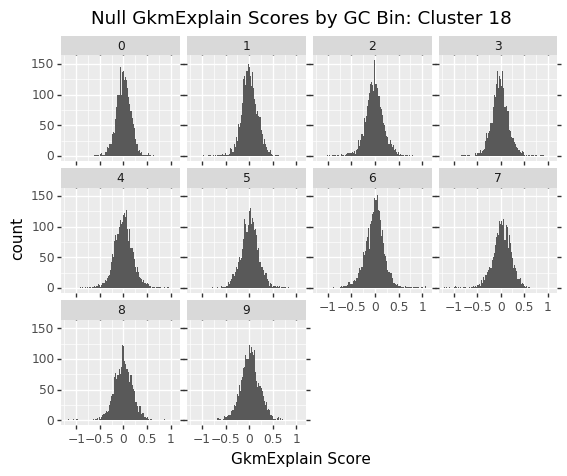

<ggplot: (-9223363282801752772)>

In [13]:
display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(bins=100)
        + labs(title='Null GkmExplain Scores by GC Bin: Cluster ' + cluster, x='GkmExplain Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null GkmExplain Scores

Fitted t Distribution: 

Mean: 	 0.005695947901397796
Stdev: 	 0.16222595190223627

KstestResult(statistic=0.003421097476486945, pvalue=0.9548948985272143)



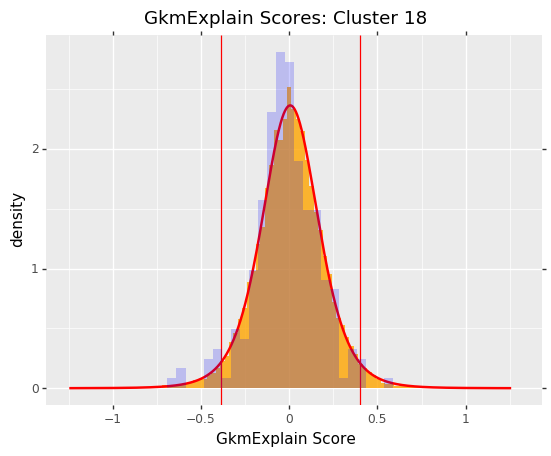

<ggplot: (8753848333218)>

In [14]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
explain_params = distrib.fit(merged_null_explain_scores)
x_explain = np.linspace(distrib.ppf(0.0001, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                        distrib.ppf(0.9999, *explain_params[:-2], explain_params[-2], explain_params[-1]), 10000)
y_explain = distrib.pdf(x_explain, *explain_params[:-2], explain_params[-2], explain_params[-1])
distrib_explain = pd.DataFrame(list(zip(x_explain, y_explain)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', explain_params[-2])
print('Stdev:', '\t', explain_params[-1])
print()
print(kstest(merged_null_explain_scores, distrib_name, args=[*explain_params[:-2], explain_params[-2], explain_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='GkmExplain Scores: Cluster ' + cluster, x='GkmExplain Score')
        + geom_line(data=distrib_explain, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='explain_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null ISM Score Distribution by GC Bin

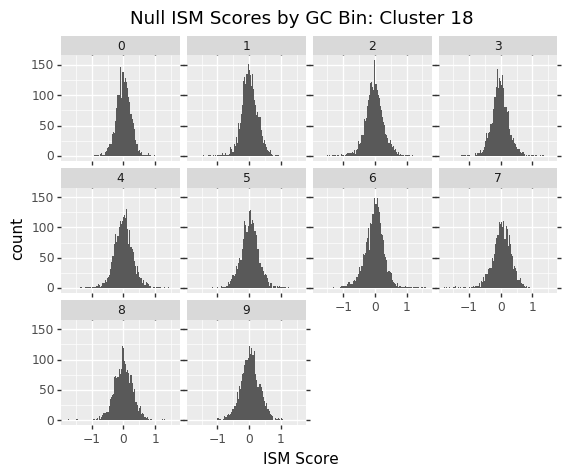

<ggplot: (8753848327011)>

In [15]:
display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(bins=100)
        + labs(title='Null ISM Scores by GC Bin: Cluster ' + cluster, x='ISM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null ISM Scores

Fitted t Distribution: 

Mean: 	 0.008508111359711572
Stdev: 	 0.24176107934338203

KstestResult(statistic=0.0031546052415253323, pvalue=0.9785626844594805)



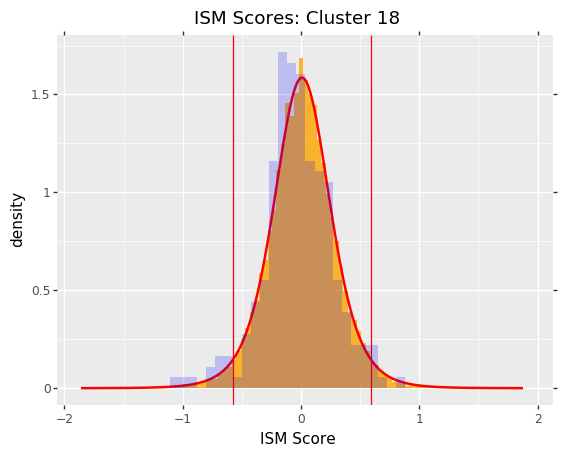

<ggplot: (8753847937519)>

In [16]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
ism_params = distrib.fit(merged_null_ism_scores)
x_ism = np.linspace(distrib.ppf(0.0001, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                        distrib.ppf(0.9999, *ism_params[:-2], ism_params[-2], ism_params[-1]), 10000)
y_ism = distrib.pdf(x_ism, *ism_params[:-2], ism_params[-2], ism_params[-1])
distrib_ism = pd.DataFrame(list(zip(x_ism, y_ism)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', ism_params[-2])
print('Stdev:', '\t', ism_params[-1])
print()
print(kstest(merged_null_ism_scores, distrib_name, args=[*ism_params[:-2], ism_params[-2], ism_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='ISM Scores: Cluster ' + cluster, x='ISM Score')
        + geom_line(data=distrib_ism, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='ism_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null deltaSVM Score Distribution by GC Bin

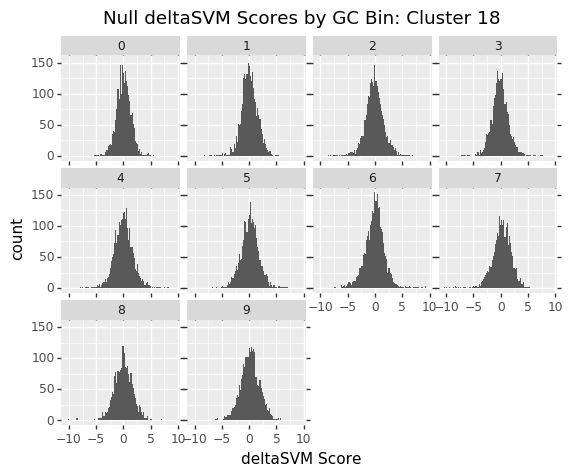

<ggplot: (8753847932543)>

In [17]:
display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(bins=100)
        + labs(title='Null deltaSVM Scores by GC Bin: Cluster ' + cluster, x='deltaSVM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null deltaSVM Scores

Fitted t Distribution: 

Mean: 	 0.04923681646976516
Stdev: 	 1.3981069098777503

KstestResult(statistic=0.00296315623642035, pvalue=0.9890562941200739)



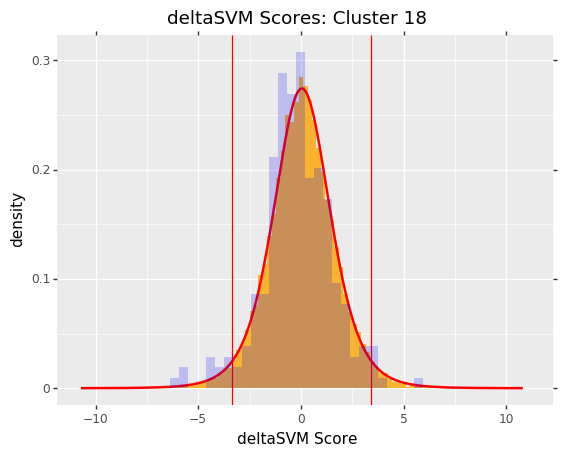

<ggplot: (-9223363283006875055)>

In [18]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
delta_params = distrib.fit(merged_null_delta_scores)
x_delta = np.linspace(distrib.ppf(0.0001, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                        distrib.ppf(0.9999, *delta_params[:-2], delta_params[-2], delta_params[-1]), 10000)
y_delta = distrib.pdf(x_delta, *delta_params[:-2], delta_params[-2], delta_params[-1])
distrib_delta = pd.DataFrame(list(zip(x_delta, y_delta)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', delta_params[-2])
print('Stdev:', '\t', delta_params[-1])
print()
print(kstest(merged_null_delta_scores, distrib_name, args=[*delta_params[:-2], delta_params[-2], delta_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='deltaSVM Scores: Cluster ' + cluster, x='deltaSVM Score')
        + geom_line(data=distrib_delta, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='delta_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Magnitude Score Distribution by GC Bin

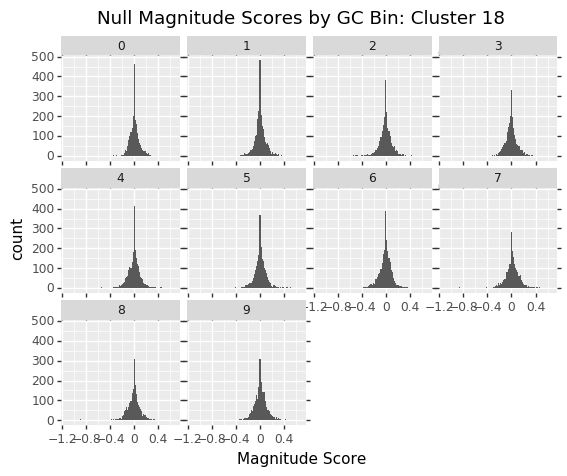

<ggplot: (8753847506159)>

In [19]:
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Magnitude Scores by GC Bin: Cluster ' + cluster, x='Magnitude Score')
        + facet_wrap("gc_bin"))

# Plot All Null Magnitude Scores

Fitted t Distribution: 

Mean: 	 0.0014512508505407197
Stdev: 	 0.0662216940369798

KstestResult(statistic=0.03608883993311773, pvalue=7.043907445635297e-26)



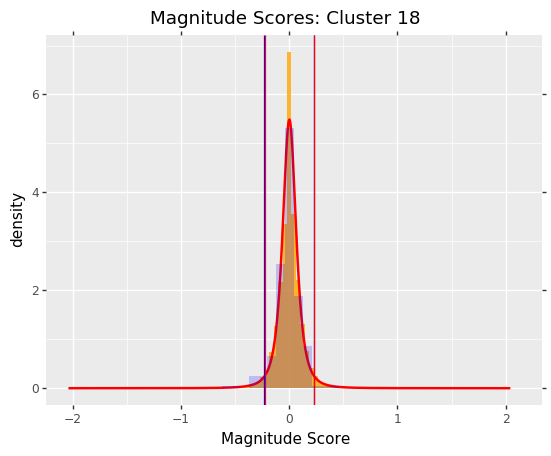

<ggplot: (-9223363283007275509)>

In [20]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
magnitude_params = distrib.fit(null_confidence_dict['null_magnitude_score'])
x_magnitude = np.linspace(distrib.ppf(0.0001, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]),
                        distrib.ppf(0.9999, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]), 10000)
y_magnitude = distrib.pdf(x_magnitude, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])
distrib_magnitude = pd.DataFrame(list(zip(x_magnitude, y_magnitude)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', magnitude_params[-2])
print('Stdev:', '\t', magnitude_params[-1])
print()
print(kstest(null_confidence_dict['null_magnitude_score'], distrib_name, args=[*magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]]))
print()

null_magnitude_quantiles = list(null_scores['null_magnitude_score'].quantile([0.025, 0.975]))
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Magnitude Scores: Cluster ' + cluster, x='Magnitude Score')
        + geom_line(data=distrib_magnitude, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='magnitude_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Prominence Score Distribution by GC Bin

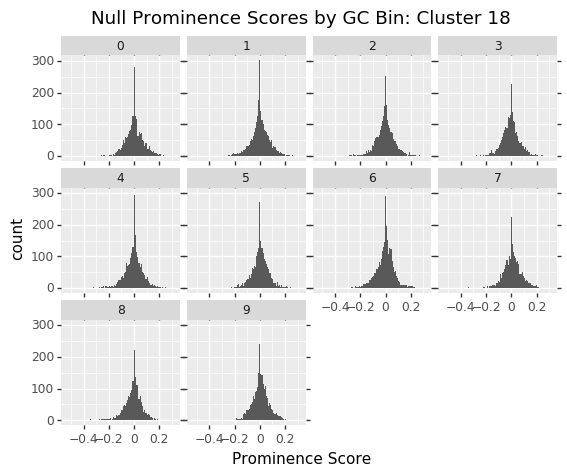

<ggplot: (-9223363283007269751)>

In [21]:
display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Prominence Scores by GC Bin: Cluster ' + cluster, x='Prominence Score')
        + facet_wrap("gc_bin"))

# Plot All Null Prominence Scores

Fitted t Distribution: 

Mean: 	 0.0008959378053043333
Stdev: 	 0.051981997373575076

KstestResult(statistic=0.0322005678780411, pvalue=1.0891562515795901e-20)



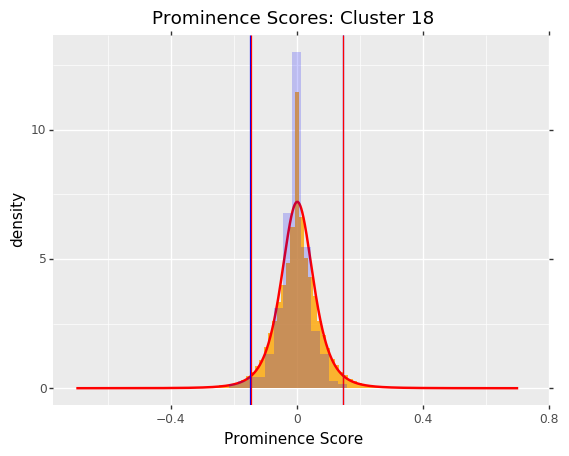

<ggplot: (-9223363283006654176)>

In [22]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
prominence_params = distrib.fit(null_confidence_dict['null_prominence_score'])
x_prominence = np.linspace(distrib.ppf(0.0001, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]),
                        distrib.ppf(0.9999, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]), 10000)
y_prominence = distrib.pdf(x_prominence, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])
distrib_prominence = pd.DataFrame(list(zip(x_prominence, y_prominence)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', prominence_params[-2])
print('Stdev:', '\t', prominence_params[-1])
print()
print(kstest(null_confidence_dict['null_prominence_score'], distrib_name, args=[*prominence_params[:-2], prominence_params[-2], prominence_params[-1]]))
print()
null_prominence_quantiles = list(null_scores['null_prominence_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Prominence Scores: Cluster ' + cluster, x='Prominence Score')
        + geom_line(data=distrib_prominence, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='prominence_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Importance Scores

Fitted t Distribution: 

Mean: 	 0.002981652081134541
Stdev: 	 0.008238304855028022

KstestResult(statistic=0.01622426559212181, pvalue=4.6253195884436016e-229)



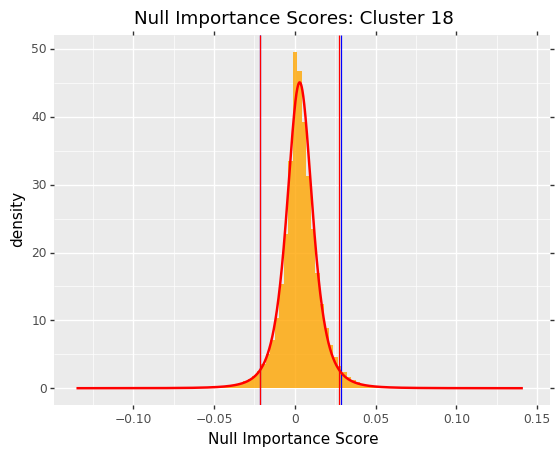

<ggplot: (8753848041848)>

In [23]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
sampled_null_importance_scores = random.sample(null_importance_scores, 1000000)
null_importance_df = pd.DataFrame(sampled_null_importance_scores, columns=['null_importance_score'])
importance_params = distrib.fit(sampled_null_importance_scores)
x_importance = np.linspace(distrib.ppf(0.0001, *importance_params[:-2], importance_params[-2], importance_params[-1]),
                           distrib.ppf(0.9999, *importance_params[:-2], importance_params[-2], importance_params[-1]), 10000)
y_importance = distrib.pdf(x_importance, *importance_params[:-2], importance_params[-2], importance_params[-1])
distrib_importance = pd.DataFrame(list(zip(x_importance, y_importance)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', importance_params[-2])
print('Stdev:', '\t', importance_params[-1])
print()
print(stats.kstest(sampled_null_importance_scores, distrib_name, args=[*importance_params[:-2], importance_params[-2], importance_params[-1]]))
print()
null_importance_quantiles = list(null_importance_df['null_importance_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_importance_df, mapping=aes(x='null_importance_score'))       
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Null Importance Scores: Cluster ' + cluster, x='Null Importance Score')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[1]), color='blue')
        + geom_line(data=distrib_importance, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red'))

# Get P-values for SNP Scores <a name='calculate_pvals' />

In [24]:
snp_scores['explain_pval'] = [(2 * min(distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                                      1 - distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]))) \
                              for x in snp_scores['explain_score']]
snp_scores['ism_pval'] = [(2 * min(distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                                  1 - distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]))) \
                              for x in snp_scores['ism_score']]
snp_scores['delta_pval'] = [(2 * min(distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                                  1 - distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]))) \
                              for x in snp_scores['delta_score']]
snp_scores['magnitude_pval'] = [(2 * min((percentileofscore(list(null_scores['null_magnitude_score']), x) / 100),
                                         (1 - (percentileofscore(list(null_scores['null_magnitude_score']), x) / 100)))) \
                                for x in snp_scores['magnitude_score']]
snp_scores['prominence_pval'] = [(2 * min((percentileofscore(list(null_scores['null_prominence_score']), x) / 100),
                                          (1 - (percentileofscore(list(null_scores['null_prominence_score']), x) / 100)))) \
                                 for x in snp_scores['prominence_score']]

confidence_values = []

for index, row in snp_scores.iterrows():
    confidence = -1
    if row['explain_pval'] < 0.05 and row['ism_pval'] < 0.05 and row['delta_pval'] < 0.5:
        confidence += 1
        if row['prominence_pval'] < 0.05:
            confidence += 2
        elif row['magnitude_pval'] < 0.05 or row['prominence_pval'] < 0.10:
            confidence += 1
    confidence_values.append(confidence)

snp_scores['confidence'] = confidence_values
snp_scores.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_scores/Cluster'
                       + cluster + '.' + celltype + '.updated.snp_scores.tsv', sep='\t', index=False)

sig_snps = snp_scores.loc[snp_scores['confidence'] >= 0].copy()
sig_snps = sig_snps.loc[sig_snps['effect'] != 'NAN']
sig_snps = sig_snps.loc[sig_snps['noneffect'] != 'NAN']
unique_sig_snps = sig_snps.sort_values(by=['rsid','prominence_pval'])
unique_sig_snps.drop_duplicates(subset=['rsid'], inplace=True)
unique_sig_snps.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
unique_sig_snps.sort_values(by=['confidence'], ascending=False, inplace=True)

print('Unique Significant SNPs:')
print()
display(unique_sig_snps)
display(unique_sig_snps.shape)
print()
print('SNPs with Significant Scores:', '\t', '\t', '\t', len(unique_sig_snps))
print('Significant SNPs with Low Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 0]))
print('Significant SNPs with Moderate Confidence:', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 1]))
print('Significant SNPs with High Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 2]))
print()
print('Total SNPs Tested: ', '\t', '\t', '\t', '\t', len(snp_scores))
print('Unique SNPs Tested: ', '\t', '\t', '\t', '\t', len(snp_scores.sort_values(by='rsid').drop_duplicates(subset='rsid')))

Unique Significant SNPs:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_motif,inactive_motif,diff_motif,active_allele,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence
175,chr2,127128581,127128582,rs13025717,T,C,C,T,C,T,+,77,0.434,-0.621288,-0.968812,-5.509292,-0.565092,-0.207862,1,Alzheimers_Jansen_2018,9.130000e-17,False,GCCCCGCCCAAT,GCCCTGCCCAAT,GCCC(C/T)GCCCAAT,noneffect,0.007631,0.006203,0.006649,0.003733,0.017067,2
190,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.658,-0.602903,-0.949359,-5.501970,-0.509892,-0.163801,8,Chang_23andMe_Parkinsons,2.349340e-03,False,GAGGGCGCTGTT,GAGGGTGCTGTT,GAGGG(C/T)GCTGTT,noneffect,0.008749,0.006819,0.006691,0.005156,0.037689,2
104,chr17,75088242,75088243,rs55827552,G,A,A,G,A,G,+,61,0.695,0.402375,0.637587,3.716174,0.274411,0.151932,9,Alzheimers_Kunkle_2019,1.869000e-03,True,GAGGGCGCTC,AAGGGCGCTC,(G/A)AGGGCGCTC,effect,0.048371,0.038996,0.037749,0.028178,0.045333,2
198,chr4,960458,960459,rs3733345,T,G,G,"A,T",T,"G,A",-,102,0.659,-0.465106,-0.734386,-4.254234,-0.286273,-0.150519,8,23andme_PD_hg38,3.350000e-10,True,GGCGGGTCCCG,GGCTGGTCCCG,GGC(G/T)GGTCCCG,noneffect,0.025915,0.020699,0.020442,0.026933,0.049511,2
219,chr4,89837895,89837896,rs2619363,T,G,G,"C,T",G,"C,T",+,103,0.527,-0.458287,-0.697023,-4.185723,-0.310882,-0.133956,3,23andme_PD_hg38,1.430000e-08,True,CCAATCAGCGC,CCAATCAGCTC,CCAATCAGC(G/T)C,noneffect,0.027418,0.025403,0.021808,0.020978,0.069067,1
106,chr17,78426790,78426791,rs72914885,C,A,A,C,A,C,-,62,0.607,-0.430897,-0.666659,-3.914236,-0.314145,-0.128162,6,Nalls_23andMe,4.467170e-02,False,TGGAACTGCCA,TGGACCTGCCA,TGGA(A/C)CTGCCA,noneffect,0.034465,0.030074,0.028275,0.020711,0.077156,1
165,chr19,45326535,45326536,rs344791,C,G,G,C,C,G,-,71,0.543,-0.672337,-1.066649,-6.146557,-0.181093,-0.120941,4,Alzheimers_Jansen_2018,1.220000e-04,True,ACCGCCTCCA,ACCCCCTCCA,ACC(G/C)CCTCCA,noneffect,0.005275,0.003913,0.003939,0.086667,0.091733,1
21,chr11,86103987,86103988,rs1237999,G,A,G,A,A,G,-,16,0.338,0.412802,0.643327,3.686414,0.317556,0.118260,0,Alzheimers_Jansen_2018,7.140000e-16,False,TGAGTCACCAACAA,TAAGTCACCAACAA,T(G/A)AGTCACCAACAA,effect,0.044247,0.037746,0.038870,0.017422,0.096178,1
105,chr17,78426733,78426734,rs72914883,G,A,A,G,A,G,-,62,0.608,0.431212,0.677037,3.916988,0.381479,0.091872,6,Nalls_23andMe,4.461790e-02,False,CCGCGCAAGCGCTTCCTGCT,CCACGCAAGCGCTTCCTGCT,CC(G/A)CGCAAGCGCTTCCTGCT,effect,0.037841,0.031212,0.031021,0.008711,0.168800,1
220,chr5,103120549,103120550,rs26523,T,C,C,T,C,T,-,104,0.543,-0.409858,-0.640925,-3.686346,-0.138406,-0.086586,4,Nalls_23andMe,1.084830e-03,False,GAGGCGGCTG,GAGGTGGCTG,GAGG(C/T)GGCTG,noneffect,0.041176,0.034751,0.035290,0.156267,0.190133,0


(11, 32)


SNPs with Significant Scores: 	 	 	 11
Significant SNPs with Low Confidence: 	 	 2
Significant SNPs with Moderate Confidence: 	 5
Significant SNPs with High Confidence: 	 	 4

Total SNPs Tested:  	 	 	 	 237
Unique SNPs Tested:  	 	 	 	 209


# Visualize High Confidence SNPs <a name='visualize_high_conf' />


Index: 175

RSID: rs13025717 	 	 || 	 chr2 : 127128581 - 127128582 	 || 	 Locus: 77

GWAS: Alzheimers_Jansen_2018 	 || 	 P-Value: 9.1300E-17 	 	 || 	 Coloc: False

Prominence P-Value: 1.7067E-02 	 || 	 Magnitude P-Value: 3.7333E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 7.6314E-03 	 || 	 ISM P-Value: 6.2035E-03 	 || 	 deltaSVM P-Value: 6.6492E-03

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Motif: GCCCCGCCCAAT



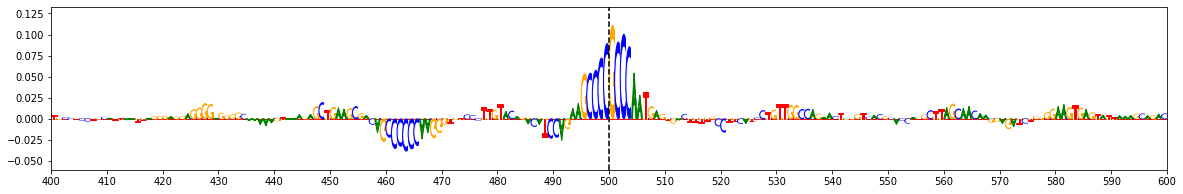


Effect Allele: T 	 	 || 	 Inactive Motif: GCCCTGCCCAAT



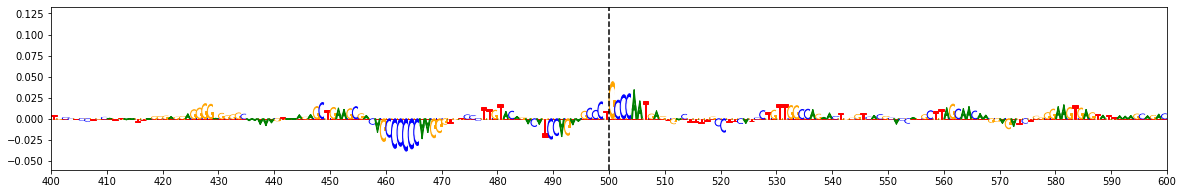


Difference Motif: GCCC(C/T)GCCCAAT



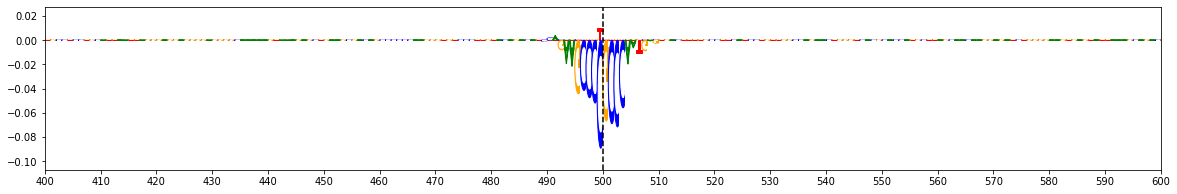


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 190

RSID: rs6781790 	 	 || 	 chr3 : 49007333 - 49007334 	 || 	 Locus: 92

GWAS: Chang_23andMe_Parkinsons 	 || 	 P-Value: 2.3493E-03 	 	 || 	 Coloc: False

Prominence P-Value: 3.7689E-02 	 || 	 Magnitude P-Value: 5.1556E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 8.7490E-03 	 || 	 ISM P-Value: 6.8186E-03 	 || 	 deltaSVM P-Value: 6.6905E-03

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Motif: GAGGGCGCTGTT



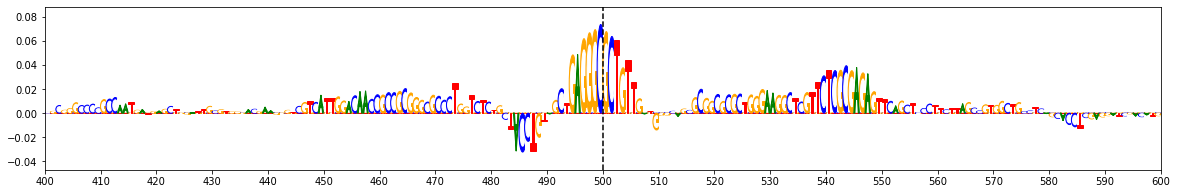


Effect Allele: T 	 	 || 	 Inactive Motif: GAGGGTGCTGTT



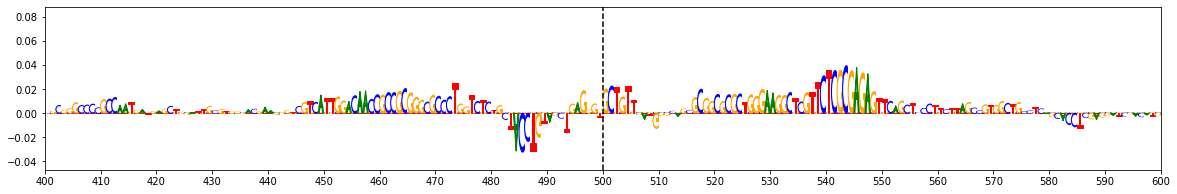


Difference Motif: GAGGG(C/T)GCTGTT



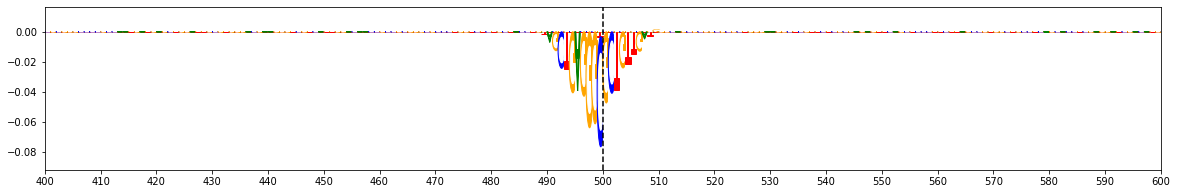


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 104

RSID: rs55827552 	 	 || 	 chr17 : 75088242 - 75088243 	 || 	 Locus: 61

GWAS: Alzheimers_Kunkle_2019 	 || 	 P-Value: 1.8690E-03 	 	 || 	 Coloc: True

Prominence P-Value: 4.5333E-02 	 || 	 Magnitude P-Value: 2.8178E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 4.8371E-02 	 || 	 ISM P-Value: 3.8996E-02 	 || 	 deltaSVM P-Value: 3.7749E-02

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Motif: GAGGGCGCTC



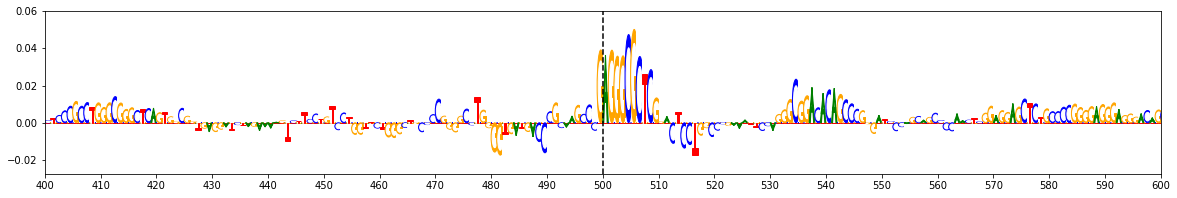


Non-Effect Allele: A 	 	 || 	 Inactive Motif: AAGGGCGCTC



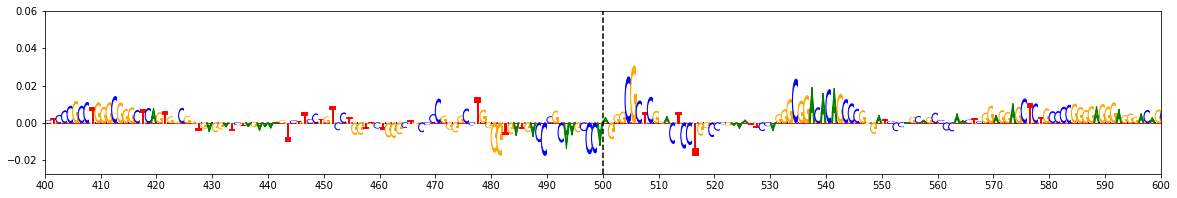


Difference Motif: (G/A)AGGGCGCTC



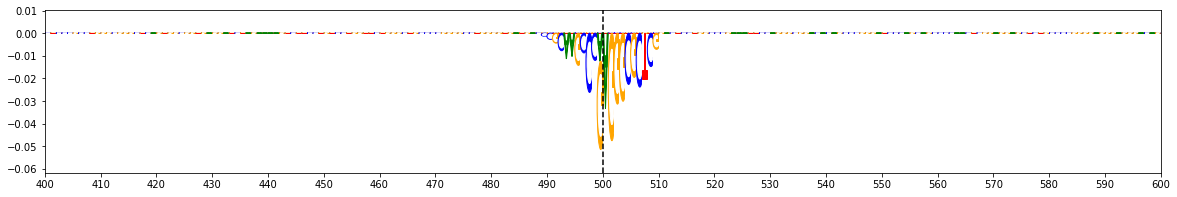


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 198

RSID: rs3733345 	 	 || 	 chr4 : 960458 - 960459 	 || 	 Locus: 102

GWAS: 23andme_PD_hg38 	 || 	 P-Value: 3.3500E-10 	 	 || 	 Coloc: True

Prominence P-Value: 4.9511E-02 	 || 	 Magnitude P-Value: 2.6933E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 2.5915E-02 	 || 	 ISM P-Value: 2.0699E-02 	 || 	 deltaSVM P-Value: 2.0442E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: G 	 	 || 	 Active Motif: GGCGGGTCCCG



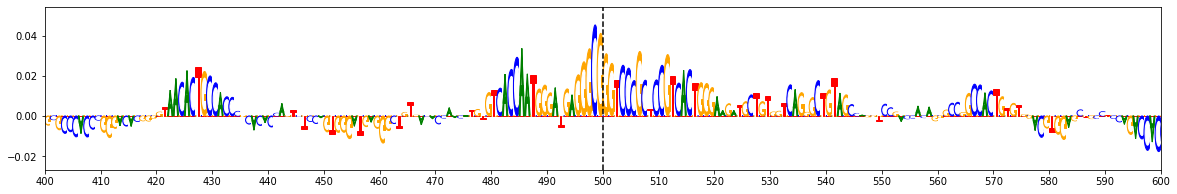


Effect Allele: T 	 	 || 	 Inactive Motif: GGCTGGTCCCG



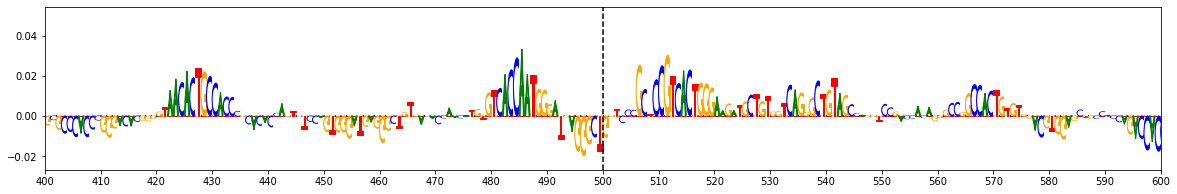


Difference Motif: GGC(G/T)GGTCCCG



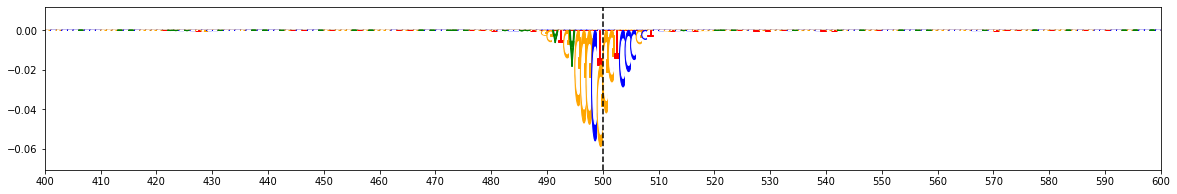


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [25]:
for index,row in unique_sig_snps.loc[unique_sig_snps['confidence'] == 2].iterrows():
    print()
    print('Index:', index)
    print()
    print('RSID:', row['rsid'],
          '\t', '\t', '||', '\t',
          row['chr'], ':', row['start'], '-', row['end'],
          '\t', '||', '\t',
          'Locus:', row['locus_num'])
    print()
    print('GWAS:', row['gwas'],
          '\t', '||', '\t',
          'P-Value:', '%.4E' % Decimal(row['gwas_pval']),
          '\t', '\t', '||', '\t',
          'Coloc:', row['coloc'])
    print()
    print('Prominence P-Value:', '%.4E' % Decimal(row['prominence_pval']),
          '\t', '||', '\t',
          'Magnitude P-Value:', '%.4E' % Decimal(row['magnitude_pval']),
          '\t', '||', '\t',
          'Confidence:', row['confidence'])
    print()
    print('GkmExplain P-Value:', '%.4E' % Decimal(row['explain_pval']),
          '\t', '||', '\t',
          'ISM P-Value:', '%.4E' % Decimal(row['ism_pval']),
          '\t', '||', '\t',
          'deltaSVM P-Value:', '%.4E' % Decimal(row['delta_pval']))    
    print()
    print('-'*100)
    print()
    
    #--------------------------------------#
    
    if row['active_allele'] == 'effect':
        if row['effect'] != 'NAN':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        print()
        ylim = plot_weights(merged_real_effect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NAN':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        print()
        ylim = plot_weights(merged_real_noneffect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
        
    #--------------------------------------#
        
    if row['active_allele'] != 'effect':
        if row['effect'] != 'NAN':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        print()
        a = plot_weights(merged_real_effect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NAN':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        print()
        a = plot_weights(merged_real_noneffect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    
    #--------------------------------------#
    
    print('Difference Motif:', row['diff_motif'])
    print()
    if row['active_allele'] == 'effect':
        a = plot_weights(merged_real_noneffect_scores[index] - merged_real_effect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    else:
        a = plot_weights(merged_real_effect_scores[index] - merged_real_noneffect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    print()
    print('-'*100)
    print('-'*100)
    print()

## Generate Signal Tracks

In [26]:
fc_tracks = []
pval_tracks = []

for index, row in unique_sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/'+rsid+'.pval.png')
        
unique_sig_snps['fc_track'] = fc_tracks
unique_sig_snps['pval_track'] = pval_tracks

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.04556632041931152
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

# Final Significant SNPs Table <a name='prep_final_table' />

In [27]:
final_sig_snps = unique_sig_snps[['chr', 'start', 'end', 'rsid',
                                  'effect', 'noneffect', 'major', 'minor', 'direction',
                                  'locus_num', 'gwas', 'gwas_pval', 'coloc',
                                  'explain_pval', 'ism_pval', 'delta_pval',
                                  'magnitude_pval', 'prominence_pval', 'confidence',
                                  'active_motif', 'diff_motif', 'active_allele',
                                  'fc_track', 'pval_track']]

final_sig_snps.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_sig_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.unique.sig_snps.tsv', sep='\t', index=False)
print('Final Significant SNPs Table:')
print()
display(final_sig_snps)

Final Significant SNPs Table:



,chr,start,end,rsid,effect,noneffect,major,minor,direction,locus_num,gwas,gwas_pval,coloc,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence,active_motif,diff_motif,active_allele,fc_track,pval_track
175,chr2,127128581,127128582,rs13025717,T,C,C,T,+,77,Alzheimers_Jansen_2018,9.130000e-17,False,0.007631,0.006203,0.006649,0.003733,0.017067,2,GCCCCGCCCAAT,GCCC(C/T)GCCCAAT,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
190,chr3,49007333,49007334,rs6781790,T,C,T,C,+,92,Chang_23andMe_Parkinsons,2.349340e-03,False,0.008749,0.006819,0.006691,0.005156,0.037689,2,GAGGGCGCTGTT,GAGGG(C/T)GCTGTT,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
104,chr17,75088242,75088243,rs55827552,G,A,A,G,+,61,Alzheimers_Kunkle_2019,1.869000e-03,True,0.048371,0.038996,0.037749,0.028178,0.045333,2,GAGGGCGCTC,(G/A)AGGGCGCTC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
198,chr4,960458,960459,rs3733345,T,G,T,"G,A",-,102,23andme_PD_hg38,3.350000e-10,True,0.025915,0.020699,0.020442,0.026933,0.049511,2,GGCGGGTCCCG,GGC(G/T)GGTCCCG,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
219,chr4,89837895,89837896,rs2619363,T,G,G,"C,T",+,103,23andme_PD_hg38,1.430000e-08,True,0.027418,0.025403,0.021808,0.020978,0.069067,1,CCAATCAGCGC,CCAATCAGC(G/T)C,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
106,chr17,78426790,78426791,rs72914885,C,A,A,C,-,62,Nalls_23andMe,4.467170e-02,False,0.034465,0.030074,0.028275,0.020711,0.077156,1,TGGAACTGCCA,TGGA(A/C)CTGCCA,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
165,chr19,45326535,45326536,rs344791,C,G,C,G,-,71,Alzheimers_Jansen_2018,1.220000e-04,True,0.005275,0.003913,0.003939,0.086667,0.091733,1,ACCGCCTCCA,ACC(G/C)CCTCCA,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
21,chr11,86103987,86103988,rs1237999,G,A,A,G,-,16,Alzheimers_Jansen_2018,7.140000e-16,False,0.044247,0.037746,0.038870,0.017422,0.096178,1,TGAGTCACCAACAA,T(G/A)AGTCACCAACAA,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
105,chr17,78426733,78426734,rs72914883,G,A,A,G,-,62,Nalls_23andMe,4.461790e-02,False,0.037841,0.031212,0.031021,0.008711,0.168800,1,CCGCGCAAGCGCTTCCTGCT,CC(G/A)CGCAAGCGCTTCCTGCT,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
220,chr5,103120549,103120550,rs26523,T,C,C,T,-,104,Nalls_23andMe,1.084830e-03,False,0.041176,0.034751,0.035290,0.156267,0.190133,0,GAGGCGGCTG,GAGG(C/T)GGCTG,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
